In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
path = "/Users/lilli/Desktop/mflex/data/Analytic_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:16:46 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 33 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 1 are of type NOTICE
 - 29 are of type VARIABLE
--------------------------------------------------
Available variables:
 - b2dx1 [<class 'numpy.ndarray'>]
 - b2dy1 [<class 'numpy.ndarray'>]
 - b2dz1 [<class 'numpy.ndarray'>]
 - d2d1 [<class 'numpy.ndarray'>]
 - b2dx2 [<class 'numpy.ndarray'>]
 - b2dy2 [<class 'numpy.ndarray'>]
 - b2dz2 [<class 'numpy.ndarray'>]
 - d2d2 [<class 'numpy.ndarray'>]
 - b2dx3 [<class 'numpy.ndarray'>]
 - b2dy3 [<class 'numpy.ndarray'>]
 - b2dz3 [<class 'numpy.ndarray'>]
 - d2d3 [<class 'numpy.ndarray'>]
 - b2dx4 [<class 'numpy.ndarray'>]
 - b2dy4 [<class 'numpy.ndarray'>]
 - b2dz4 [<class '

In [40]:
data_bz = data["b2dz5"]
data_bx = data["b2dx5"]
data_by = data["b2dy5"]

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 40.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 40.0 * 10**-3
pixelsize_y_Mm = 40.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm
zmax_Mm = 2000.0 * 10**-3

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

nf_max = min(nresol_x, nresol_y)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

x_arr = np.arange(nresol_x) * (xmax_Mm - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax_Mm - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

xmax_Mm, ymax_Mm, zmax_Mm 3.2 3.2 2.0
nresol_x, nresol_y, nresol_z 80 80 50
pixelsize_x 0.04
pixelsize_y 0.04
pixelsize_z 0.04


In [6]:
path3dref = "/Users/lilli/Desktop/mflex/data/Analytic_3D_data.sav"
data3dref = readsav(path3dref, python_dict=True, verbose=True)

bx_ref = data3dref["b3dx"]
by_ref = data3dref["b3dy"]
bz_ref = data3dref["b3dz"]

presref = data3dref["p3d"] * 10**-1
denref = data3dref["d3d"] * 10**3

issi_bx = np.zeros((nresol_y, nresol_x, nresol_z))
issi_by = np.zeros_like(issi_bx)
issi_bz = np.zeros_like(issi_bx)

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            issi_bx[i, j, k] = bx_ref[k, i, j]
            issi_by[i, j, k] = by_ref[k, i, j]
            issi_bz[i, j, k] = bz_ref[k, i, j]

B_ref = np.array((issi_by, issi_bx, issi_bz))

--------------------------------------------------
Date: Tue Sep  6 15:11:11 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 1 are of type NOTICE
 - 8 are of type VARIABLE
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


In [7]:
print(B_ref.shape)

(3, 80, 80, 50)


In [9]:
B_ref_See = np.zeros((nresol_y, nresol_x, nresol_z, 3))

for iz in range(0, nresol_z):
    for ix in range(0, nresol_x):
        for iy in range(0, nresol_y):
            for id in range(0, 3):
                B_ref_See[iy, ix, iz, id] = B_ref[id, iy, ix, iz]

In [10]:
print(B_ref_See.shape)

(80, 80, 50, 3)


In [15]:
from msat.pyvis.fieldline3d import fieldline3d

In [16]:
sinks = B_ref_See[:, :, 0, 2].copy()
sources = B_ref_See[:, :, 0, 2].copy()

maxmask = sources < sources.max() * 0.4
sources[maxmask != 0] = 0

minmask = sinks < sinks.min() * 0.4
sinks[minmask == 0] = 0

In [19]:
xmin, xmax, ymin, ymax, zmin, zmax = (
        x_big[0],
        x_big[-1],
        y_big[0],
        y_big[-1],
        z_arr[0],
        z_arr[-1],
    )

h1 = 1.0 / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

# Limit fieldline plot to original data size (rather than Seehafer size)
boxedges = np.zeros((2, 3))

# # Y boundaries must come first, X second due to switched order explained above
boxedges[0, 0] = ymin
boxedges[1, 0] = ymax
boxedges[0, 1] = xmin
boxedges[1, 1] = xmax
boxedges[0, 2] = zmin
boxedges[1, 2] = zmax

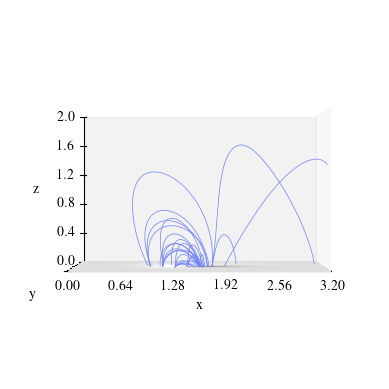

In [38]:
fig = plt.figure()
ax = fig.figure.add_subplot(111, projection="3d")

x_big = np.arange(nresol_x) * 3.2 / (nresol_x - 1) 
y_big = np.arange(nresol_y) * 3.2 / (nresol_y - 1) 

x_grid, y_grid = np.meshgrid(x_big, y_big)
ax.contourf(
    x_grid,
    y_grid,
    B_ref_See[:, :, 0, 2],
    1000,
    # norm=norm,
    cmap=cmap,
    offset=0.0,
)
for ix in range(0, nresol_x, int(nresol_x / 20)):
        for iy in range(0, nresol_y, int(nresol_y / 20)):
            if sources[iy, ix] != 0 or sinks[iy, ix] != 0:

                x_start = ix / (nresol_x / xmax)
                y_start = iy / (nresol_y / ymax)

                if B_ref_See[int(y_start), int(x_start), 0, 2] < 0.0:
                    h1 = -h1

                ystart = [y_start, x_start, 0.0]

                fieldline = fieldline3d(
                    ystart,
                    B_ref_See,
                    y_big,
                    x_big,
                    z_arr,
                    h1,
                    hmin,
                    hmax,
                    eps,
                    oneway=False,
                    boxedge=boxedges,
                    gridcoord=False,
                    coordsystem="cartesian",
                )  # , periodicity='xy')

                if np.isclose(fieldline[:, 2][-1], 0.0) and np.isclose(
                    fieldline[:, 2][0], 0.0
                ):
                    # Need to give row direction first/ Y, then column direction/ X
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )
                else:
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )

ax.view_init(30, 240, 0)  # type: ignore
ax.view_init(0, -90) 
ax.set_xlabel("x", labelpad=5)
ax.set_zlabel("z", labelpad=10)  # type: ignore

ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
ax.set_zticks(np.arange(0, zmax + 1.0 * 10**-8, zmax / 5))  # type: ignore

ax.set_yticklabels([])  # type: ignore
ax.set_ylabel("")

[t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

[t.set_va("center") for t in ax.get_zticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_zticklabels()]  # type: ignore
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")  # type: ignore
ax.grid(False)
ax.set_zlim(zmin, zmax)  # type: ignore
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_box_aspect((xmax, ymax, zmax))